In [222]:
%pylab inline
import numpy as np
from tqdm import trange
import datetime
import pandas as pd
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [108]:
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            dat = f.read()
    else:
        with open(fp, 'wb') as f:
            dat = requests.get(url).content
            f.write(dat)
    return gzip.decompress(dat)



In [131]:
#get years 2005-2020
raw_data = []
for year in range(2004, 2020):
    raw_data.append(fetch(f'https://www.ndbc.noaa.gov/data/historical/stdmet/46225h{year}.txt.gz'))

In [132]:
# get 2020 up to august
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
for i, month in enumerate(months):
    raw_data.append(fetch(f'https://www.ndbc.noaa.gov/data/stdmet/{month}/46225{i+1}2020.txt.gz'))

In [149]:
# make datafame and clean up
data = []
cols = []
for month in raw_data:
    m = month.decode('ascii').split('\n')
    cols = m[0].split()
    for line in m[2:]:
        l = np.array(line.split())
        l = np.asfarray(l)
        if len(l) == 18:
            data.append(l)
data = np.stack(data)
df = pd.DataFrame(data)
df.columns = cols
df = df.drop(columns=['WDIR', 'WSPD', 'GST', 'PRES', 'ATMP', 'DEWP', 'VIS', 'TIDE'])
df['#YY'] = df['#YY'].apply(int)
df['MM'] = df['MM'].apply(int)
df['DD'] = df['DD'].apply(int)
df['hh'] = df['hh'].apply(int)
df['mm'] = df['mm'].apply(int)
df['Date'] = pd.to_datetime(
    df['#YY'].astype(str) + '-'
    + df['MM'].astype(str) + '-' 
    + df['DD'].astype(str) + ' ' 
    + df['hh'].astype(str) + ":" 
    + df['mm'].astype(str))

df = df.drop(columns=['#YY', 'MM', 'DD', 'hh', 'mm'])
df['WVHT'] = df['WVHT'] * 3.28
df['WTMP'] = df['WTMP'] * (9/5) + 32
df.drop(df[df.WVHT > 50].index, inplace=True)
df.drop(df[df.WTMP > 90].index, inplace=True)
df.drop(df[df.APD > 50].index, inplace=True)
df.drop(df[df.MWD > 360].index, inplace=True)
df['month'] = df['Date'].dt.month
df.head()

,WVHT,DPD,APD,MWD,WTMP,Date
25345,6.2320,7.69,6.10,280.0,56.66,2008-01-30 17:51:00
25346,6.3960,7.69,6.04,277.0,56.66,2008-01-30 18:21:00
25347,6.5600,7.69,6.16,282.0,56.66,2008-01-30 18:51:00
25348,6.5272,7.14,6.14,286.0,56.66,2008-01-30 19:21:00
25349,5.8384,6.67,5.88,286.0,56.66,2008-01-30 19:51:00


<AxesSubplot:xlabel='Date'>

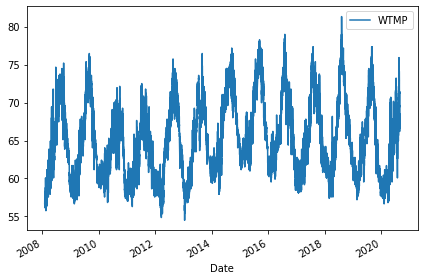

In [233]:
df.plot(x='Date', y='WTMP')

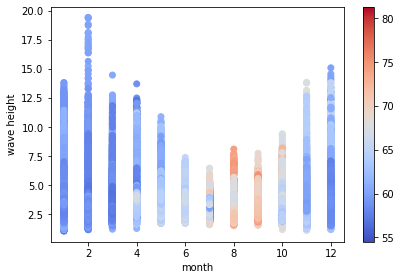

In [235]:
plt.scatter(x=df['month'], 
            y=df['WVHT'],  
            c=df['WTMP'],
            cmap='coolwarm')
plt.xlabel('month')
plt.ylabel('wave height')
plt.colorbar()
plt.show()